<a href="https://colab.research.google.com/github/durml91/Personal/blob/main/Transformer_implementation_II.5%20-%20New%20datasets%20and%20pretrained%20models%20test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Transformer (Encoder-Decoder) Implementation**

## Installs and Imports

*Nvidia CUDA version check*

In [ ]:
# !nvcc --version
# !cat /usr/local/cuda/version.txt
# !cat /usr/include/x86_64-linux-gnu/cudnn_v*.h | grep CUDNN_MAJOR -A 2

**Install datasets before updating JAX**

In [1]:
!pip install datasets[jax]
!pip install tokenizers
!pip install transformers
!pip install einops
!pip install equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 MB 7.9 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.3.25-py3-none-any.whl size=1308495 sha256=ca779151c0b953331e4240ce8c8570bfc58c9a812eeca34db58776658def3800
  Stored in directory: /root/.cache/pip/wheels/41/0b/45/1acffcaf4c863a6d0d0e910e56ae6502ca8d16300e39e1dab2
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.13+cuda11.cudnn86
    Uninstalling jaxlib-0

In [2]:
#!pip install jaxlib==0.4.13+cuda11.cudnn86 -f  https://storage.googleapis.com/jax-releases/jax_cuda_releases.html # [cuda]

!pip install -U jax jaxlib # [cpu]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 10.9 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.25
    Uninstalling jaxlib-0.3.25:
      Successfully uninstalled jaxlib-0.3.25


*Restart runtime here!*

In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp

import einops

import equinox as eqx

import optax

import tqdm
from tqdm import notebook as tqdm

import functools

from typing import Dict, List, Mapping, Optional, Callable
from jaxtyping import Array, Float, Int

import math

from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path

from matplotlib.pylab import plt

*Check VM is using GPU accelerator*

In [ ]:
jax.default_backend()

'gpu'

**Random key generation**

In [2]:
rand_key = jr.PRNGKey(2023)

## **Transformer**

### Transformer modules

**Generic equinox module for GELU**

In [3]:
class Lambda(eqx.Module):

    fn: Callable

    def __call__(self, x, *, key=None):
        return self.fn(x)

**Attention**

In [4]:
def causal_attention_mask(x):
    dim = x.shape[0]

    mask = jnp.ones((dim, dim), dtype=float)
    mask = jnp.tril(mask, k=0)
    return mask == 1

In [5]:
class AttentionBlock(eqx.Module):

    attention: eqx.nn.MultiheadAttention
    dropout: eqx.nn.Dropout
    num_heads: int = eqx.field(static=True)

    def __init__(
        self,
        d_model: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey
    ):
        self.num_heads = num_heads
        self.attention = eqx.nn.MultiheadAttention(
            num_heads=num_heads,
            query_size=d_model,
            use_query_bias=True,
            use_key_bias=True,
            use_value_bias=True,
            use_output_bias=True,
            dropout_p=attention_dropout_rate,
            key=key,
        )

        self.dropout = eqx.nn.Dropout(dropout_rate)


    def make_attention_mask(
        self, mask, q: Int[Array, "query_seq_len"], kv: Int[Array, "kv_seq_len"],
    ) -> Float[Array, "num_heads query_seq_len kv_seq_len"]:

        qsl = q.shape[0]
        kvsl = kv.shape[0]

        if mask.shape[0] != qsl:
            mask = einops.repeat(mask, " a b -> (a q) b", q = qsl)

        mask = jnp.where(mask, 1.0, 0.0)    # mask == True
        mask = jnp.expand_dims(mask, axis=-3)
        mask = jnp.repeat(mask, repeats=self.num_heads, axis=-3)

        return mask.astype(jnp.float32)


    def __call__(
        self,
        query: Float[Array, "seq_len d_model"],
        key_: Float[Array, "seq_len d_model"],
        value: Float[Array, "seq_len d_model"],
        mask,
        enable_dropout: bool = False,
        key: "jr.PRNGKey" = None,
    ) -> Float[Array, "seq_len d_model"]:

        if mask is not None:
            mask = self.make_attention_mask(mask, query, key_)

        attention_key, dropout_key = (
            (None, None) if key is None else jr.split(key)
        )

        attention_output = self.attention(
              query=query,
              key_=key_,
              value=value,
              mask=mask,
              inference=not enable_dropout,
              key=attention_key
        )

        att_drop = self.dropout(attention_output, inference=not enable_dropout, key=dropout_key)

        return att_drop

*Below is a breakdown of how the attention mask is actually used in equinox*

In [ ]:
# logits = jr.normal(rand_key, shape=(10,10))

# mask = jnp.ones((10,10))
# mask = jnp.tril(mask, k=0)

# #mask = jnp.where(mask==1., -jnp.inf, mask)

# print(mask)
# print(logits)
# logits1 = jnp.where(mask, logits, jnp.finfo(logits.dtype).min)
# #print(logits1)
# logits2 = jnp.where(mask==1, logits, jnp.finfo(logits.dtype).min)
# #print(logits2)

# print(logits1 - logits2)

**MLP Block**

In [7]:
class FeedForwardBlock(eqx.Module):

    mlp: eqx.nn.Sequential    #could also use MLP if this way is more fiddly
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        dropout_rate: float,
        key: jr.PRNGKey,
    ):
        linear1, linear2 = jr.split(key)

        self.mlp = eqx.nn.Sequential([
            eqx.nn.Linear(in_features=d_model, out_features=intermediate_size, key=linear1),
            Lambda(jax.nn.gelu),
            eqx.nn.Linear(in_features=intermediate_size, out_features=d_model, key=linear2)
        ])
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(
        self,
        inputs: Float[Array, "seq_len d_model"],
        enable_dropout: bool = True,
        key: Optional[jr.PRNGKey] = None,
    ) -> Float[Array, "seq_len d_model"]:

        feed_out = jax.vmap(self.mlp)(inputs)
        out_d = self.dropout(feed_out, inference=not enable_dropout, key=key)

        return out_d


**Embedding table**

In [8]:
class InputEmbeddings(eqx.Module):

  embedding: eqx.nn.Embedding
  d_model: int

  def __init__(
      self,
      d_model: int,
      vocab_size: int,
      key: jr.PRNGKey,
  ):
      self.d_model = d_model
      self.embedding = eqx.nn.Embedding(vocab_size, d_model, key=key)

  def __call__(self, x) -> Float[Array, "seq_len d_model"]:

    return self.embedding(x) * math.sqrt(self.d_model)

**Positional encoding**

In [9]:
class SinusoidalPosEmb(eqx.Module):
    pos_emb: jax.Array
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        d_model: int,
        seq_len: int,
        dropout_rate: float
    ):
        self.dropout = eqx.nn.Dropout(dropout_rate)
        half_dim = d_model//2
        pe = jnp.zeros((seq_len, d_model))
        position = einops.repeat(jnp.arange(0 , seq_len), " s -> s r", r=half_dim)  #shape [seq_len, d_model/2]
        div_term = jnp.exp(jnp.arange(0, d_model, 2) * -(math.log(10_000) / d_model))  #shape [d_model/2]
        ins = jax.vmap(jnp.multiply, in_axes=(1, 0), out_axes=1)(position, div_term)  #shape [seq_len, d_model/2]

        pe = pe.at[:, 0::2].set(jnp.sin(ins))
        pe = pe.at[:, 1::2].set(jnp.cos(ins))

        self.pos_emb = pe

    def __call__(
        self,
        x,
        enable_dropout: bool = False,
        key: "jr.PRNGKey" = None,
    ) -> Float[Array, "seq_len d_model"]:

        x = x + jax.lax.stop_gradient(self.pos_emb[:x.shape[0], :])

        return self.dropout(x, inference=not enable_dropout, key=key)

####### to freeze parameters, can also use eqx.partition or "try" filter(static=True) ######

**Encoder Block**

In [10]:
class EncoderLayer(eqx.Module):

    layer_norm_1: eqx.nn.LayerNorm
    layer_norm_2: eqx.nn.LayerNorm
    attention_block: AttentionBlock
    ff_block: FeedForwardBlock

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

        attention_key, ff_key = jr.split(key)

        self.attention_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=attention_key,
        )
        self.ff_block = FeedForwardBlock(
            d_model=d_model,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )
        self.layer_norm_1 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_2 = eqx.nn.LayerNorm(shape=d_model)

    def __call__(
        self,
        inputs: Float[Array, "seq_len d_model"],
        mask: Optional[Int[Array, "seq_len"]] = None,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ) -> Float[Array, "seq_len d_model"]:

        attn_key, ff_key = (None, None) if key is None else jr.split(key)

        ln_inputs_1 = jax.vmap(self.layer_norm_1)(inputs)
        inputs = inputs + self.attention_block(
            ln_inputs_1, ln_inputs_1, ln_inputs_1, mask, enable_dropout=enable_dropout, key=attn_key
        )
        ln_inputs_2 = jax.vmap(self.layer_norm_2)(inputs)
        inputs = inputs + self.ff_block(
            ln_inputs_2, enable_dropout=enable_dropout, key=ff_key
        )

        return inputs

**Encoder**

In [11]:
class Encoder(eqx.Module):

    embedder_block: InputEmbeddings
    pos_embed: SinusoidalPosEmb
    layers: List[EncoderLayer]

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        seq_len: int,
        intermediate_size: int,
        num_layers: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

      embedder_key, layer_key = jr.split(key, num=2)

      self.embedder_block = InputEmbeddings(
          d_model, vocab_size, key=embedder_key
      )
      self.pos_embed = SinusoidalPosEmb(d_model, seq_len, dropout_rate)

      layer_keys = jr.split(layer_key, num=num_layers)

      self.layers = [
          EncoderLayer(
              d_model=d_model, intermediate_size=intermediate_size, num_heads=num_heads, dropout_rate=dropout_rate, attention_dropout_rate=attention_dropout_rate, key=layer_key,
          )
          for layer_key in layer_keys]

    def __call__(
          self,
          tokens: Int[Array, " seq_len"],
          mask,
          *,
          enable_dropout: bool = False,
          key: Optional[jr.PRNGKey] = None,
    ):

          ps_emb_key, l_key = (None, None) if key is None else jr.split(key, 2)

          embed_inputs = self.embedder_block(tokens)
          x = self.pos_embed(embed_inputs, enable_dropout=enable_dropout, key=ps_emb_key)
          for layer in self.layers:
              cl_key, l_key = (None, None) if l_key is None else jr.split(l_key)

              x = layer(x, mask, enable_dropout=enable_dropout, key=cl_key)

          return x

**Decoder Block**

In [12]:
class DecoderLayer(eqx.Module):

    self_att_block: AttentionBlock
    cross_att_block: AttentionBlock
    ff_block: FeedForwardBlock
    layer_norm_1: eqx.nn.LayerNorm
    layer_norm_2: eqx.nn.LayerNorm
    layer_norm_3: eqx.nn.LayerNorm

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

        self_att_key, cross_att_key, ff_key = jr.split(key, num=3)

        self.self_att_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=self_att_key,
        )
        self.cross_att_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=cross_att_key,
        )
        self.ff_block = FeedForwardBlock(
            d_model=d_model,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )
        self.layer_norm_1 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_2 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_3 = eqx.nn.LayerNorm(shape=d_model)

    def __call__(
        self,
        inputs: Float[Array, "seq_len d_model"],
        encoder_output,
        src_mask,
        tgt_mask,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ):

        self_attn_key, cross_attn_key, ff_key = (None, None, None) if key is None else jr.split(key, num=3)

        ln_inputs_1 = jax.vmap(self.layer_norm_1)(inputs)
        inputs = inputs + self.self_att_block(
            ln_inputs_1, ln_inputs_1, ln_inputs_1, tgt_mask, enable_dropout=enable_dropout, key=self_attn_key
        )
        ln_inputs_2 = jax.vmap(self.layer_norm_2)(inputs)
        inputs = inputs + self.cross_att_block(
            ln_inputs_2, encoder_output, encoder_output, src_mask, enable_dropout=enable_dropout, key=cross_attn_key
        )
        ln_inputs_3 = jax.vmap(self.layer_norm_3)(inputs)
        inputs = inputs + self.ff_block(
            ln_inputs_3, enable_dropout=enable_dropout, key=ff_key
        )

        return inputs

**Decoder**

In [13]:
class Decoder(eqx.Module):

    embedder_block: InputEmbeddings
    pos_embed: SinusoidalPosEmb
    layers: List[DecoderLayer]

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        seq_len: int,
        intermediate_size: int,
        num_heads: int,
        num_layers: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey
    ):
        embedder_key, layer_key = jr.split(key, num=2)

        self.embedder_block = InputEmbeddings(
          d_model, vocab_size, embedder_key
        )
        self.pos_embed = SinusoidalPosEmb(d_model, seq_len, dropout_rate)
        layer_keys = jr.split(layer_key, num=num_layers)

        self.layers = [
          DecoderLayer(
              d_model=d_model, intermediate_size=intermediate_size, num_heads=num_heads, dropout_rate=dropout_rate, attention_dropout_rate=attention_dropout_rate, key=layer_key,
          )
          for layer_key in layer_keys]

    def __call__(
        self,
        x,
        encoder_output,
        src_mask,
        tgt_mask,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ):

        ps_emb_key, l_key = (None, None) if key is None else jr.split(key, 2)

        embed_inputs = self.embedder_block(x)
        x = self.pos_embed(embed_inputs, key=ps_emb_key)
        for layer in self.layers:
              cl_key, l_key = (None, None) if l_key is None else jr.split(l_key)

              x = layer(x, encoder_output, src_mask, tgt_mask, enable_dropout=enable_dropout, key=cl_key)


        return x

**Final Layer**

In [14]:
class Out_Projection_Layer(eqx.Module):

    proj: eqx.nn.Linear

    def __init__(
        self,
        d_model:int,
        vocab_size: int,
        key: jr.PRNGKey
    ):
        self.proj = eqx.nn.Linear(in_features=d_model, out_features=vocab_size, key=key)

    def __call__(
        self,
        x
    ) -> Int[Array, "seq_len vocab_size"]:
        out = jax.vmap(self.proj)(x)

        # return jax.nn.log_softmax(out, axis=-1) # - softmax included in CE loss

        return out

**Transformer**

In [15]:
class Transformer(eqx.Module):

    encoder: Encoder
    decoder: Decoder
    out_proj: Out_Projection_Layer

    def __init__(
        self,
        config: Mapping,
        key: jr.PRNGKey
    ):

        encoder_key, decoder_key, out_proj_key = jr.split(key, num=3)

        self.encoder = Encoder(
            vocab_size=config["src_vocab_size"],
            d_model=config["d_model"],
            seq_len=config["src_seq_len"],
            intermediate_size=config["intermediate_size"],
            num_layers=config["num_hidden_layers"],
            num_heads=config["num_attention_heads"],
            dropout_rate=config["hidden_dropout_prob"],
            attention_dropout_rate=config["attention_dropout_prob"],
            key=encoder_key,
        )
        self.decoder = Decoder(
            vocab_size=config["tgt_vocab_size"],
            d_model=config["d_model"],
            seq_len=config["tgt_seq_len"],
            intermediate_size=config["intermediate_size"],
            num_layers=config["num_hidden_layers"],
            num_heads=config["num_attention_heads"],
            dropout_rate=config["hidden_dropout_prob"],
            attention_dropout_rate=config["attention_dropout_prob"],
            key=decoder_key,
        )
        self.out_proj = Out_Projection_Layer(
            d_model=config["d_model"],
            vocab_size=config["tgt_vocab_size"],
            key=out_proj_key)

    def encode(self,
               src,
               src_mask,
               enable_dropout: bool = False,
               key: Optional[jr.PRNGKey] = None
    ):
        return self.encoder(src, src_mask, enable_dropout=enable_dropout, key=key)

    def decode(self,
               enc,
               src_mask,
               tgt,
               tgt_mask,
               enable_dropout: bool = False,
               key: Optional[jr.PRNGKey] = None
    ):
        return self.decoder(tgt, enc, src_mask, tgt_mask, enable_dropout=enable_dropout, key=key)

    def project(self, x):
        return self.out_proj(x)

### *Misc*

#### *Visualisation of sinusoidal embeddings*

In [ ]:
import pandas as pd
import altair as alt

In [ ]:
def show_example(fn, args=[]):
    if __name__ == "__main__" :
        return fn(*args)

In [ ]:
def example_positional():
    pe = SinusoidalPosEmb(20, 5000, 0)
    y = pe(jnp.zeros((100, 20), dtype=jnp.float32))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[:, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

show_example(example_positional)

(100, 20) (5000, 20)


alt.Chart(...)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import to_rgb
matplotlib.rcParams['lines.linewidth']=2.0
import seaborn as sns
sns.reset_orig()

<ipython-input-148-e9e448fab539>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


<Figure size 640x480 with 0 Axes>

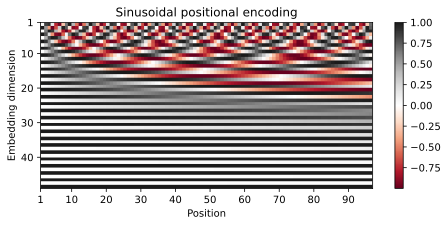

In [ ]:
encod_block = SinusoidalPosEmb(d_model=48, seq_len=96, dropout_rate=0.0)
#pe = jnp.transpose(jnp.squeeze(encod_block.pos_emb))
pe = jnp.transpose(encod_block.pos_emb)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos=ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1]+1, pe.shape[0]+1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position")
ax.set_ylabel("Embedding dimension")
ax.set_title("Sinusoidal positional encoding")

ax.set_xticks([1]+[i*10 for i in range(1, 1+pe.shape[1] //10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])

plt.show()

#### *Toy test*

In [ ]:
gpt_config = {
    "src_vocab_size": int,
    "tgt_vocab_size": int,
    "src_seq_len": int,
    "tgt_seq_len": int,
    "d_model": 512,     # - 512
    "num_hidden_layers": 6,   #N - 6
    "num_attention_heads": 8,   #h - 8
    "intermediate_size": 2048,    #d_ff - 2048
    "hidden_dropout_prob": 0.1,
    "attention_dropout_prob": 0.1,
}

new_config = {"src_vocab_size": 11,
    "tgt_vocab_size": 11,
    "src_seq_len": 10,
    "tgt_seq_len": 1}

gpt_config.update(new_config)

In [ ]:
def inf_test(test_model, inf_key):

    src = jnp.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype= int)
    src_mask = jnp.ones((1,10))

    memory = test_model.encode(src, src_mask, False, inf_key)

    ys = jnp.zeros((1), dtype= int)

    for i in range(9):
        out = test_model.decode(memory, src_mask, ys, causal_attention_mask(ys), False, inf_key)
        proj_out = test_model.project(out)
        prob = jax.nn.softmax(proj_out, axis=-1)
        h_prob = jnp.argmax(prob[-1])
        ys = jnp.concatenate([ys, jnp.array([h_prob])])
        rand_key

    print("Model Prediction:", ys)

    return inf_key

In [ ]:
inf_key = rand_key.copy()
for _ in range(10):
    inf_key = jr.split(inf_key)[0]
    test_model = Transformer(gpt_config, inf_key)
    #test_model = eqx.tree_inference(test_model, value=True)
    inf_key = inf_test(test_model, inf_key)

Model Prediction: [0 9 7 2 3 4 4 4 4 4]
Model Prediction: [0 3 2 3 2 3 2 3 2 3]
Model Prediction: [ 0  9  8  3 10  3 10  3 10  3]
Model Prediction: [0 7 1 0 7 1 0 7 1 0]
Model Prediction: [ 0  1  6 10  9  9  9  9  9  9]
Model Prediction: [0 0 0 0 0 0 0 0 0 0]
Model Prediction: [0 1 2 4 4 4 4 4 4 4]
Model Prediction: [0 5 5 5 5 5 5 5 5 5]
Model Prediction: [0 1 8 3 9 6 5 0 1 8]
Model Prediction: [0 2 2 2 2 2 2 2 2 2]


In [ ]:
# with xavier initialisation #
inf_key = rand_key.copy()
for _ in range(10):
    inf_key, init_key = jr.split(inf_key)
    init_model = Transformer(gpt_config, inf_key)
    test_model = init_parameters(init_model, xavier_init, xavier_init_b, init_key)
    inf_key = inf_test(test_model, inf_key)

Model Prediction: [0 7 0 7 0 7 0 7 0 7]
Model Prediction: [0 3 3 3 3 3 3 3 3 3]
Model Prediction: [0 3 2 5 1 6 5 1 6 5]
Model Prediction: [0 5 5 5 5 5 5 5 5 5]
Model Prediction: [0 2 6 2 6 2 6 2 6 2]
Model Prediction: [0 6 9 6 9 6 9 6 9 6]
Model Prediction: [0 6 0 6 0 6 0 6 0 6]
Model Prediction: [0 2 2 2 2 2 2 2 2 2]
Model Prediction: [0 5 8 4 4 4 4 4 4 4]
Model Prediction: [0 2 2 2 2 2 2 2 2 2]


## **Training**

**Random key split**

In [16]:
train_key, loader_key, split_key, r_init_key, c_init_key, val_key = jr.split(rand_key, 6)

**Model configuration and training hyperparameters**

In [17]:
gpt_config = {
    "src_vocab_size": int,
    "tgt_vocab_size": int,
    "src_seq_len": int,
    "tgt_seq_len": int,
    "d_model": 128,     # - 512
    "num_hidden_layers": 2,   #N - 6
    "num_attention_heads": 2,   #h - 8
    "intermediate_size": 256,    #d_ff - 2048
    "hidden_dropout_prob": 0.1,
    "attention_dropout_prob": 0.1,
    "src_lang": "en",
    "tgt_lang": "it",
    "epochs": 24,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "ds_size": int,
}

#### Data utility functions

**Tokenizer**

In [18]:
def get_or_build_tokenizer(ds, lang):

    def get_all_sentences(ds, lang):
        for item in ds:
            yield item['translation'][lang]

    tokenizer_path = Path("tokenizer_{0}.json".format(lang))

    if not Path.exists(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]","[PAD]","[SOS]","[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

**Train/Test split**

In [19]:
def rand_split(ds, train_size, val_size, key):
    ds_size = ds.shape[0]
    indices = jnp.arange(ds_size)
    perm = jr.permutation(rand_key, indices, independent=False)  # get random permutation of indices
    train_ind = perm[:train_size]
    val_ind = perm[train_size:]
    train_ds = ds[train_ind]
    val_ds = ds[val_ind]
    assert (len(train_ds["id"]) + len(val_ds["id"])) - ds_size == 0

    return (train_ds, val_ds)


**Dataset processor**

In [20]:
def process_ds(ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, src_seq_len, tgt_seq_len):
    sos_token = jnp.asarray([tokenizer_src.token_to_id("[SOS]")], dtype=int) # get sos token id from tokeniser - would be array of shape [1,]
    eos_token = jnp.asarray([tokenizer_src.token_to_id("[EOS]")], dtype=int)
    pad_token  = jnp.asarray([tokenizer_src.token_to_id("[PAD]")], dtype=int)

    src_text = ds['translation'][src_lang]
    tgt_text = ds['translation'][tgt_lang]

    enc_input_tokens = tokenizer_src.encode(src_text).ids
    dec_input_tokens =  tokenizer_tgt.encode(tgt_text).ids

    enc_num_padding_tokens = src_seq_len - len(enc_input_tokens) - 2
    dec_num_padding_tokens = tgt_seq_len - len(dec_input_tokens) - 1

    if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
        raise ValueError('Sentence is too long')

    # add SOS and EOS to source text
    encoder_input = jnp.concatenate([
        sos_token,
        jnp.asarray(enc_input_tokens),
        eos_token,
        jnp.repeat(pad_token, enc_num_padding_tokens)
    ])

    # add SOS to decoder input
    decoder_input = jnp.concatenate([
        sos_token,
        jnp.asarray(dec_input_tokens, dtype=int),
        jnp.repeat(pad_token, dec_num_padding_tokens)
    ])

    # add EOS to expected decoder output

    label = jnp.concatenate([
        jnp.asarray(dec_input_tokens, dtype=int),
        eos_token,
        jnp.repeat(pad_token, dec_num_padding_tokens)
    ])

    assert encoder_input.shape[0] == src_seq_len
    assert decoder_input.shape[0] == tgt_seq_len
    assert label.shape[0] == tgt_seq_len

    encoder_mask = jnp.expand_dims((encoder_input!= pad_token), axis=0)  # (1, seq_len)
    decoder_mask = jnp.expand_dims((encoder_input!= pad_token), axis=0) & causal_attention_mask(decoder_input) # (1 seq_len) & (seq_len seq_len)

    return encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text

In [21]:
def batch_process_ds(ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, src_seq_len, tgt_seq_len):
    sos_token = jnp.asarray([tokenizer_src.token_to_id("[SOS]")], dtype=int) # get sos token id from tokeniser - would be array of shape [1,]
    eos_token = jnp.asarray([tokenizer_src.token_to_id("[EOS]")], dtype=int)
    pad_token  = jnp.asarray([tokenizer_src.token_to_id("[PAD]")], dtype=int)


    # list comp #
    src_text = [i[src_lang] for i in ds['translation']]   # if src_lang in ds['translation'][i]
    tgt_text = [i[tgt_lang] for i in ds['translation']]

    # func #
    #get_words = lambda ds,src_lang,tgt_lang : ([i[src_lang] for i in ds['translation']], [i[tgt_lang] for i in ds['translation']])
    #src_text, tgt_text = get_words(ds, src_lang, tgt_lang)


    enc_input_tokens = [tokenizer_src.encode(i).ids for i in src_text]
    dec_input_tokens = [tokenizer_tgt.encode(i).ids for i in tgt_text]

    enc_num_padding_tokens = []
    dec_num_padding_tokens = []

    for i,j in zip(enc_input_tokens, dec_input_tokens):
        enpt = src_seq_len - len(i) - 2
        dnpt = tgt_seq_len - len(j) - 1

        if enpt < 0 or dnpt < 0:
            raise ValueError('Sentence is too long')

        enc_num_padding_tokens.append(enpt)
        dec_num_padding_tokens.append(dnpt)

    encoder_input = [jnp.concatenate([
    sos_token,
    jnp.asarray(i),
    eos_token,
    jnp.repeat(pad_token, j)
    ]) for i, j in zip(enc_input_tokens, enc_num_padding_tokens)]

    decoder_input = [jnp.concatenate([
        sos_token,
        jnp.asarray(i, dtype=int),
        jnp.repeat(pad_token, j)
    ]) for i, j in zip(dec_input_tokens, dec_num_padding_tokens)]

    label = [jnp.concatenate([
        jnp.asarray(i, dtype=int),
        eos_token,
        jnp.repeat(pad_token, j)
    ]) for i, j in zip(dec_input_tokens, dec_num_padding_tokens)]

    for i,j,k in zip(encoder_input, decoder_input, label):
        assert i.shape[0] == src_seq_len
        assert j.shape[0] == tgt_seq_len
        assert k.shape[0] == tgt_seq_len

    encoder_mask = [jnp.expand_dims((i!=pad_token), axis=0) for i in encoder_input]  # (1, seq_len)
    decoder_mask = [jnp.expand_dims((i!=pad_token), axis=0) & causal_attention_mask(j) for i,j in zip(encoder_input, decoder_input)] # (1 seq_len) & (seq_len seq_len)

    return jnp.asarray(encoder_input), jnp.asarray(decoder_input), jnp.asarray(encoder_mask), jnp.asarray(decoder_mask), jnp.asarray(label), src_text, tgt_text

**Data loader**

In [22]:
def dataloader(data, batch_size, *, key):
    dataset_size = len(data["id"])
    indices = jnp.arange(dataset_size)
    perm = jr.permutation(key, indices)  # get random permutation of indices
    (key, ) = jr.split(key, 1)
    start = 0
    end = batch_size
    while end < dataset_size:
        batch_perm = perm[start:end]
        #new_dict = {"id": [list(data["id"])[i] for i in batch_perm], "translation": [list(data["translation"])[j] for j in batch_perm]}
        new_dict = {"id": [data["id"][i] for i in batch_perm], "translation": [data["translation"][j] for j in batch_perm]}
        yield new_dict
        start = end
        end = start + batch_size

In [23]:
def new_dataloader(data, batch_size, ds_size, *, key):
    dataset_size = ds_size
    indices = jnp.arange(dataset_size)
    perm = jr.permutation(key, indices)  # get random permutation of indices
    (key, ) = jr.split(key, 1)
    start = 0
    end = batch_size
    while end < dataset_size:
        batch_perm = perm[start:end]
        yield {"encoder_inputs":data["encoder_input"][batch_perm], "encoder_masks":data["encoder_mask"][batch_perm], "decoder_inputs":data["decoder_input"][batch_perm], "decoder_masks":data["decoder_mask"][batch_perm], "labels":data["label"][batch_perm]}
        start = end
        end = start + batch_size

#### Data download and setup

In [ ]:
# def new_data(ds):
#     new_ds = {'id':[], 'en':[], 'it':[]}

#     ds_size = len(ds['translation'])
#     count=0
#     #tip = math.floor((5/100)*ds_size)
#     for i in range(50):   #ds_size

#         trans_in = ds['translation'][i]['en']
#         trans_out = ds['translation'][i]['it']
#         index = ds['id'][i]

#         new_ds['en'].append(trans_in)
#         new_ds['it'].append(trans_out)
#         new_ds['id'].append(index)

#         count+=1

#         if count % 100 == 0:
#             print(count)

#     return new_ds

In [24]:
def new_process_ds(data):
    encoder_inputs = []
    decoder_inputs = []
    encoder_masks = []
    decoder_masks = []
    labels = []


    count=0
    for i in range(gpt_config["ds_size"]):

        nd = {'id':data["id"][i], 'translation':data["translation"][i]}
        encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text = process_ds(
            nd, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
            )

        encoder_inputs.append(encoder_input)
        decoder_inputs.append(decoder_input)
        encoder_masks.append(encoder_mask)
        decoder_masks.append(decoder_mask)
        labels.append(label)

        count+=1

        if count % 1000 == 0:
            print(count)

    encoder_inputs = jnp.asarray(encoder_inputs)
    decoder_inputs = jnp.asarray(decoder_inputs)
    encoder_masks = jnp.asarray(encoder_masks)
    decoder_masks = jnp.asarray(decoder_masks)
    labels = jnp.asarray(labels)


    #return [encoder_inputs, decoder_inputs, encoder_masks, decoder_masks, labels]
    return {"encoder_input": encoder_inputs, "decoder_input": decoder_inputs, "encoder_mask": encoder_masks, "decoder_mask": decoder_masks, "label": labels}

In [25]:
# load dataset #
ds_raw = load_dataset('opus_books', f'{gpt_config["src_lang"]}-{gpt_config["tgt_lang"]}', split='train')
ds_raw = ds_raw.with_format("jax")

# tokenize input data #
tokenizer_src = get_or_build_tokenizer(ds_raw, gpt_config["src_lang"])
tokenizer_tgt = get_or_build_tokenizer(ds_raw, gpt_config["tgt_lang"])

# train/validation split #
train_ds_size = int(0.9 * len(ds_raw))
val_ds_size = len(ds_raw) - train_ds_size
train_ds_raw, val_ds_raw = rand_split(ds_raw, train_ds_size, val_ds_size, split_key)

Generating train split:   0%|          | 0/32332 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-it/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.


*Check length of sentences*

In [ ]:
max_len_src = 0
max_len_tgt = 0
for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

print(f'Max length of source sentence: {max_len_src}')
print(f'Max length of target sentence: {max_len_tgt}')

Max length of source sentence: 309
Max length of target sentence: 274


In [ ]:
len(train_ds_raw["id"])

29098

In [ ]:
t0 = train_ds_raw["translation"][0]
t1000 = train_ds_raw["translation"][1000]
t5000 = train_ds_raw["translation"][5000]
t20000 = train_ds_raw["translation"][20000]
t28000 = train_ds_raw["translation"][28000]

In [ ]:
# train_ds_raw = {"id":train_ds_raw["id"][3:28000], "translation":train_ds_raw["translation"][3:28000]}

In [ ]:
train_ds_raw = new_process_ds(train_ds_raw)

In [26]:
import shutil
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
from pickle import dump, load

In [ ]:
with open('./OpusEnItproc.pkl', 'wb') as file:
    dump(train_ds_raw, file)

import shutil
shutil.copy('./OpusEnItproc.pkl','/content/gdrive/MyDrive/Colab_Notebooks')

'/content/gdrive/MyDrive/Colab_Notebooks/OpusEnItproc.pkl'

In [28]:
train_ds_raw = load(open('gdrive/MyDrive/Colab_Notebooks/OpusEnItproc.pkl', 'rb'))

In [29]:
# update gpt configuration #
new_config = {
    "src_vocab_size": tokenizer_src.get_vocab_size(),
    "tgt_vocab_size": tokenizer_tgt.get_vocab_size(),
    "src_seq_len": 315,
    "tgt_seq_len": 315,
    "ds_size": len(train_ds_raw["encoder_input"])
    }
gpt_config.update(new_config)

In [ ]:
print(train_ds_raw["encoder_input"][0])
print(train_ds_raw["encoder_input"][1000])
print(train_ds_raw["encoder_input"][5000])
print(train_ds_raw["encoder_input"][20000])
print(train_ds_raw["encoder_input"][28000])

In [ ]:
print(tokenizer_src.encode(t0["en"]).ids)
print(tokenizer_src.encode(t1000["en"]).ids)
print(tokenizer_src.encode(t5000["en"]).ids)
print(tokenizer_src.encode(t20000["en"]).ids)
print(tokenizer_src.encode(t28000["en"]).ids)

[12, 486, 9, 40, 76]
[712, 17, 14, 11, 363, 10, 4291, 108, 5, 3696, 10, 1370, 583, 4, 10, 1043, 54, 8585, 4, 54, 5, 0, 10, 583, 108, 136, 14, 25, 466, 25, 9192, 6, 57, 534, 61, 26, 20, 2923, 7]
[296, 4179]
[340, 485, 161, 1536, 6, 6728, 72, 17, 7]
[35, 298, 4, 69, 1453, 34, 314, 4, 9, 12, 316, 1239, 17, 30, 95, 280, 18, 9, 1418, 24, 15, 74]


#### Training loop

**Loss functions**

*Without label smoothing*

In [30]:
def compute_loss(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key):   # key
    batch_size = encoder_inputs.shape[0]
    batch_keys = jr.split(key, num=2*batch_size)
    encoder_output = jax.vmap(model.encode, in_axes=(0, 0, None, 0))(encoder_inputs, encoder_masks, True, batch_keys[0:batch_size])
        #encoder_output = jax.vmap(functools.partial(model.encode, enable_dropout=True), in_axes=(0, 0, 0))(encoder_inputs, encoder_masks, batch_keys[0:8])
    decoder_output = jax.vmap(model.decode, in_axes=(0, 0, 0, 0, None, 0))(encoder_output, encoder_masks, decoder_inputs, decoder_masks, True, batch_keys[batch_size:2*batch_size])
    proj_output = jax.vmap(model.project, in_axes=0)(decoder_output)
    logits = einops.rearrange(proj_output, "b s v -> (b s) v") # , b=batch_size, s = proj_output[1], tokenizer_tgt.get_vocab_size())
    labels = einops.rearrange(labels, " b s -> (b s)")
    pad_pos = tokenizer_tgt.token_to_id("[PAD]")
    pad_mask = jnp.where(labels==pad_pos, 0., 1.)
    # label smoothing #
    oh_labels = jax.nn.one_hot(labels, tokenizer_tgt.get_vocab_size())
    oh_labels = oh_labels.at[:, pad_pos].set(0.)
    # s_labels = optax.smooth_labels(oh_labels, alpha=0.1)
    # s_labels = s_labels.at[:, pad_pos].set(0.)

    logits=logits.at[:, pad_pos].set(-1e3)

    loss = optax.softmax_cross_entropy(logits=logits, labels=oh_labels)
    loss_masked = loss * pad_mask

    return jnp.sum(loss_masked)/jnp.sum(pad_mask)   # loss_masked

*With label smoothing*

In [ ]:
def compute_loss(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key):   # key
    batch_size = encoder_inputs.shape[0]
    batch_keys = jr.split(key, num=2*batch_size)
    encoder_output = jax.vmap(model.encode, in_axes=(0, 0, None, 0))(encoder_inputs, encoder_masks, True, batch_keys[0:batch_size])
        #encoder_output = jax.vmap(functools.partial(model.encode, enable_dropout=True), in_axes=(0, 0, 0))(encoder_inputs, encoder_masks, batch_keys[0:8])
    decoder_output = jax.vmap(model.decode, in_axes=(0, 0, 0, 0, None, 0))(encoder_output, encoder_masks, decoder_inputs, decoder_masks, True, batch_keys[batch_size:2*batch_size])
    proj_output = jax.vmap(model.project, in_axes=0)(decoder_output)
    logits = einops.rearrange(proj_output, "b s v -> (b s) v") # , b=batch_size, s = proj_output[1], tokenizer_tgt.get_vocab_size())
    labels = einops.rearrange(labels, " b s -> (b s)")
    pad_pos = tokenizer_tgt.token_to_id("[PAD]")
    pad_mask = jnp.where(labels==pad_pos, 0., 1.)
    # label smoothing #
    oh_labels = jax.nn.one_hot(labels, tokenizer_tgt.get_vocab_size())
    oh_labels = oh_labels.at[:, pad_pos].set(0.)
    s_labels = optax.smooth_labels(oh_labels, alpha=0.1)

    #s_labels = s_labels * pad_mask

    loss = optax.softmax_cross_entropy(logits=logits, labels=s_labels)
    loss_masked = loss * pad_mask

    return jnp.sum(loss_masked)/jnp.sum(pad_mask)   # loss_masked

*Make update step*

In [31]:
@eqx.filter_jit
def make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt_update, key):  # key
    key, new_key = jr.split(key)
    loss_fn = eqx.filter_value_and_grad(compute_loss)
    loss, grads = loss_fn(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key) # key
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return loss, model, opt_state, new_key

**Model initialisation** - *Including custom Xavier uniform initialisation*

In [32]:
# weight initialiser #
def xavier_init(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, param.shape)
    return params

# bias initialiser #
def xavier_init_b(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, (1, param.shape[0]))
    params = jnp.squeeze(params, axis=0)
    return params

# initiliase custom model parameters #
def init_parameters(model, init_fn, init_fn_b, key):

    wkey, bkey, ekey = jr.split(key, 3)

    is_linear = lambda x: isinstance(x, eqx.nn.Linear)

    get_weights = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey) for weight, subkey in zip(weights, jr.split(wkey, len(weights)))]
    model_w = eqx.tree_at(get_weights, model, new_weights)

    get_biases = lambda m: [x.bias for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    biases = get_biases(model_w)
    new_biases = [init_fn_b(bias, subkey) for bias, subkey in zip(biases, jr.split(bkey, len(biases)))]
    model_wb = eqx.tree_at(get_biases, model_w, new_biases)

    is_embedding = lambda x: isinstance(x, eqx.nn.Embedding)

    get_embs = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_embedding) if is_embedding(x)]
    embs = get_embs(model_wb)
    new_embs = [init_fn(embedding, subkey) for embedding, subkey in zip(embs, jr.split(ekey, len(embs)))]
    new_model = eqx.tree_at(get_embs, model_wb, new_embs)

    return new_model

In [33]:
# custom model initialisation #
init_model = Transformer(gpt_config, r_init_key)
model = init_parameters(init_model, xavier_init, xavier_init_b, c_init_key)

**Optimiser initialisation**  - *including clipping grad norm and learning rate schedule*

In [34]:
# setup optax #
# opt = optax.inject_hyperparams(optax.adam)(learning_rate = optax.warmup_cosine_decay_schedule(
#     init_value=1e-9, peak_value=1e-3, warmup_steps= 0.2*gpt_config["epochs"], decay_steps = 0.8*gpt_config["epochs"]
# ))
opt = optax.adam(learning_rate=gpt_config["learning_rate"])
opt = optax.chain(optax.clip_by_global_norm(1.0), opt)

opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

**Training loop**

*Time-saving loop attempt*

In [37]:
train_loss = {}   # for graphing training loss
epochs = gpt_config["epochs"]
for epoch in range(epochs):
    with tqdm.tqdm(
        new_dataloader(train_ds_raw, gpt_config["batch_size"], gpt_config["ds_size"], key=loader_key),
        total = gpt_config["ds_size"]//gpt_config["batch_size"],
        unit = "steps",
        desc = f"Epoch {epoch+1}/{epochs}",
    ) as tqdm_epoch:
        for data in tqdm_epoch:

            tr_loss, model, opt_state, train_key = make_step(model, data["encoder_inputs"], data["encoder_masks"], data["decoder_inputs"], data["decoder_masks"], data["labels"], opt_state, opt.update, train_key)

            tqdm_epoch.set_postfix(loss = tr_loss)
    loader_key = jr.split(loader_key, 1)[0]
    train_loss[epoch]=tr_loss

Epoch 1/24:   0%|          | 0/909 [00:00<?, ?steps/s]

KeyboardInterrupt: ignored

*Normal loop*

In [ ]:
train_loss = {}   # for graphing training loss
epochs = gpt_config["epochs"]
for epoch in range(gpt_config["epochs"]):
    with tqdm.tqdm(
        dataloader(train_ds_raw, gpt_config["batch_size"], key=loader_key),
        total = len(train_ds_raw["translation"])//gpt_config["batch_size"],
        unit = "steps",
        desc = f"Epoch {epoch+1}/{epochs}",
    ) as tqdm_epoch:
        for data in tqdm_epoch:
            encoder_inputs = []
            decoder_inputs = []
            encoder_masks = []
            decoder_masks = []
            labels = []
            for i in range(gpt_config["batch_size"]):
                id = data["id"][i]
                trans = data["translation"][i]
                new_dict = {"id":id, "translation":trans}
                encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text = process_ds(
                    new_dict, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
                    )

                encoder_inputs.append(encoder_input)
                decoder_inputs.append(decoder_input)
                encoder_masks.append(encoder_mask)
                decoder_masks.append(decoder_mask)
                labels.append(label)

            encoder_inputs = jnp.asarray(encoder_inputs)
            decoder_inputs = jnp.asarray(decoder_inputs)
            encoder_masks = jnp.asarray(encoder_masks)
            decoder_masks = jnp.asarray(decoder_masks)
            labels = jnp.asarray(labels)

            tr_loss, model, opt_state, train_key = make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt.update, train_key)

            tqdm_epoch.set_postfix(loss = tr_loss)
    loader_key = jr.split(loader_key, 1)[0]
    train_loss[epoch]=tr_loss

Epoch 1/1000:   0%|          | 0/454 [00:00<?, ?steps/s]

Epoch 2/1000:   0%|          | 0/454 [00:00<?, ?steps/s]

KeyboardInterrupt: ignored

*Batched loop*

In [ ]:
# train_loss = {}   # for graphing training loss
# epochs = gpt_config["epochs"]
# for epoch in range(epochs):
#     with tqdm.tqdm(
#         dataloader(train_ds_raw, gpt_config["batch_size"], key=loader_key),
#         total = len(train_ds_raw["translation"])//gpt_config["batch_size"],
#         unit = "steps",
#         desc = f"Epoch {epoch+1}/{epochs}",
#     ) as tqdm_epoch:
#         for data in tqdm_epoch:
#             encoder_inputs, decoder_inputs, encoder_masks, decoder_masks, labels, src_text, tgt_text = batch_process_ds(
#                 data, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
#                 )

#             tr_loss, model, opt_state, train_key = make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt.update, train_key)

#             tqdm_epoch.set_postfix(loss = tr_loss)
#     loader_key = jr.split(loader_key, 1)[0]
#     train_loss[epoch]=tr_loss

*With validation*

In [ ]:
# train_loss = {}   # for graphing training loss
# #val_loss = {}
# epochs = gpt_config["epochs"]
# for epoch in range(epochs):
#     with tqdm.tqdm(
#         dataloader(train_ds_raw, gpt_config["batch_size"], key=loader_key),
#         total = len(train_ds_raw["translation"])//gpt_config["batch_size"],
#         unit = "steps",
#         desc = f"Epoch {epoch+1}/{epochs}",
#     ) as tqdm_epoch:
#         for data in tqdm_epoch:
#             encoder_inputs, decoder_inputs, encoder_masks, decoder_masks, labels, src_text, tgt_text = batch_process_ds(
#                 data, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
#                 )

#             tr_loss, model, opt_state, train_key = make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt.update, train_key)

#             tqdm_epoch.set_postfix(loss = tr_loss)

#     run_validation(model, val_ds_raw, tokenizer_src, tokenizer_tgt, 10, 2, val_key)
#     loader_key = jr.split(loader_key, 1)[0]
#     val_key = jr.split(val_key, 1)[0]
#     train_loss[epoch]=tr_loss

**Plot loss curve**

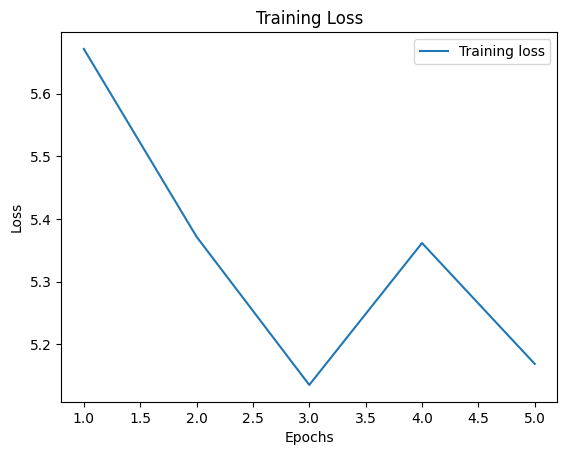

In [ ]:
epcs = jnp.arange(1, epochs+1, step=1)
plt.plot(epcs, train_loss.values(), label='Training loss')

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

#plt.xticks(jnp.arange(0, epochs+1, steps=2))

plt.legend(loc='best')
plt.show()

## **Inference**

In [41]:
def greedy_decode(
    model,
    source,
    source_mask,
    tokenizer_src,
    tokenizer_tgt,
    max_len
):
    sos_idx = jnp.asarray(tokenizer_tgt.token_to_id("[SOS]"))
    eos_idx = jnp.asarray(tokenizer_tgt.token_to_id("[EOS]"))

    # This computation now gets used repeatedly
    encoder_output = model.encode(source, source_mask)

    decoder_input = jnp.asarray([sos_idx])    # SOS token to start decoding

    while True:
        if decoder_input.shape[0] == max_len:
            break
        else:
            decoder_mask = causal_attention_mask(decoder_input)
            out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)
            prob = jax.nn.softmax(model.project(out), axis=-1)
            next_word = jnp.asarray([jnp.argmax(prob[-1])])
            decoder_input = jnp.concatenate([decoder_input, next_word])
            if next_word == eos_idx:
                break

    return decoder_input

In [42]:
def run_validation(
    model,
    validation_ds,
    tokenizer_src,
    tokenizer_tgt,
    max_len,
    num_examples,
    val_key
):

    inference_model = eqx.tree_inference(model, value=True)



    # match with training loop and process ds
    val_ds = next(dataloader(validation_ds, batch_size=num_examples, key=val_key))

    encoder_inputs, decoder_inputs, encoder_masks, decoder_masks, labels, src_text, tgt_text = batch_process_ds(
            val_ds, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
            )

    model_out = [greedy_decode(model, i, j, tokenizer_src, tokenizer_tgt, max_len) for i,j in zip(encoder_inputs, encoder_masks)]

    model_out_text = [tokenizer_tgt.decode(mo) for mo in model_out]

    for i in range(num_examples):

        print(f'SOURCE: {src_text[i]}')
        print(f'TARGET: {tgt_text[i]}')
        print(f'PREDICTED: {model_out_text[i]}')


In [ ]:
val_key = jr.split(val_key, 1)[0]
run_validation(model, val_ds_raw, tokenizer_src, tokenizer_tgt, 10, 2, val_key)

SOURCE: 'Yes, I will go,' said Anna, recovering and rousing herself; 'and if a telegram comes during my absence, send it to Darya Alexandrovna's...
TARGET: — Sì, andrò — disse Anna tornando in sé e alzandosi. — E se verrà un telegramma quando non ci sarò, mandatemelo da Dar’ja Aleksandrovna.
PREDICTED: — Sì , andrò — disse Anna , Anna
SOURCE: CHAPTER XV.
TARGET: CAPITOLO XV.
PREDICTED: XV


In [43]:
val_key = jr.split(val_key, 1)[0]
run_validation(model, val_ds_raw, tokenizer_src, tokenizer_tgt, 10, 2, val_key)

SOURCE: "Not I. The utmost I hope is, to save money enough out of my earnings to set up a school some day in a little house rented by myself."
TARGET: — Nessuna; tutto ciò che spero si è di guadagnare abbastanza per potere un giorno aprire una scuola in una casetta affittata da me.
PREDICTED: e e e e e e e e e
SOURCE: CHAPTER VII
TARGET: VII
PREDICTED: 


## New + different dataset

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "google/bert_uncased_L-2_H-128_A-2", model_max_length=128
)


def tokenize(example):
    return tokenizer(example["sentence"], padding="max_length", truncation=True)


ds = load_dataset("sst2")
ds = ds.map(tokenize, batched=True)
ds.set_format(type="jax", columns=["input_ids", "token_type_ids", "label"])

In [ ]:
ds.shape

{'train': (67349, 6), 'validation': (872, 6), 'test': (1821, 6)}

In [ ]:
ds['train']['input_ids'].shape

(67349, 128)

In [ ]:
a  =ds["train"].iter(batch_size=8, drop_last_batch=True)

In [ ]:
b = next(a)

In [ ]:
b

{'label': Array([0, 1, 0, 0, 0, 0, 0, 1], dtype=int32),
 'input_ids': Array([[  101,  1037, 14777, ...,     0,     0,     0],
        [  101,  2024,  2062, ...,     0,     0,     0],
        [  101,  3632,  2000, ...,     0,     0,     0],
        ...,
        [  101,  2387,  2129, ...,     0,     0,     0],
        [  101, 18496,  2070, ...,     0,     0,     0],
        [  101,  1996,  4602, ...,     0,     0,     0]], dtype=int32),
 'token_type_ids': Array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)}